# Instructions

The final project consists in the preparation of a short study on one of the topics of the course, identifying a
precise research question and measurable objectives. The project will propose a methodology for solving the
research question and provide an experimental verification of the results obtained according to results evaluation
metrics. The emphasis is not on obtaining high performance but rather on the critical discussion of the results
obtained in order to understand the potential effectiveness of the proposed methodology.

The results must be documented in a short article of not less than 4 pages and no more than 8, composed
according to the guidelines available here: template and using the corresponding or MS Word templates.
Students have also to provide access to a GitHub repository containing the code and reproducible experimental
results.
Finally, the project will be discussed after a 10 minutes presentation in English with slides.

Paper Structure:

Introduction
Provides an overview of the project and a short dicsussion on the pertinent literature
2. Research question and methodology
Provides a clear statement on the goals of the project, an overview of the proposed approach, and a formal
definition of the problem
3. Experimental results
Provides an overview of the dataset used for experiments, the metrics used for evaluating performances,
and the experimental methodology. Presents experimental results as plots and/or tables
4. Concluding remarks
Provides a critical discussion on the experimental results and some ideas for future work

# Project description

Write me (P8)
The extraction of information elements from unstructured text is a widely addressed research problem in the field
of text mining. E-mail and chat messages are characterized not only by a partially structured form, which includes
for example fixed formulas and metadas, but also by a dialogical and dynamic nature. 
Following these considerations, the research project could approach the problem of extracting information content from e-mail
message texts on three different levels, not necessarily all mandatory:

- Structural elements: Extract the formal elements of the single e-mail messages, such as the pleasantries and the
signature, but also themes and topics.
- Non-structural elements: All the elements that are expected in an email but are not structural, such as arguments.
The problem of argument mining in particular has received and continues to receive great attention in the
scientific literature.
- Dialogues: Extension of the previous tasks to a dialogical environment, such as a chat.

Dataset links: 
- https://www.kaggle.com/datasets/kaggle/email-dataset
- https://www.kaggle.com/datasets/kaggle/enron-email-dataset
- https://www.kaggle.com/datasets/kaggle/fraudulent-email-dataset

References: 

"Agrawal, S., Chakrabarti, K., Chaudhuri, S., & Ganti, V. (2008). Scalable ad-hoc entity extraction from text
collections. Proceedings of the VLDB Endowment, 1(1), 945-957."

"Al-Moslmi, T., Ocaña, M. G., Opdahl, A. L., & Veres, C. (2020). Named entity extraction for knowledge graphs:
A literature overview. IEEE Access, 8, 32862-32881."

"Hong, T., Cho, J., Yu, H., Ko, Y., & Seo, J. (2023). Knowledge-grounded dialogue modelling with dialogue-state
tracking, domain tracking, and entity extraction. Computer Speech & Language, 78, 101460."

# Import libraries

In [1]:
import pandas as pd
import re
import os
import spacy
import nltk
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from bertopic import BERTopic
import time
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from transformers import pipeline
from spacy.matcher import Matcher
from wordcloud import WordCloud
import os
import pickle
import json
from PIL import Image
from wordcloud import STOPWORDS

from utils import *
from preprocess import *
general_path = '/Users/baroski/Documents/Cursor/information_retrieval/v2/'

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/baroski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/baroski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/baroski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/baroski/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
tqdm.pandas()
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load datasets

## Clinton emails

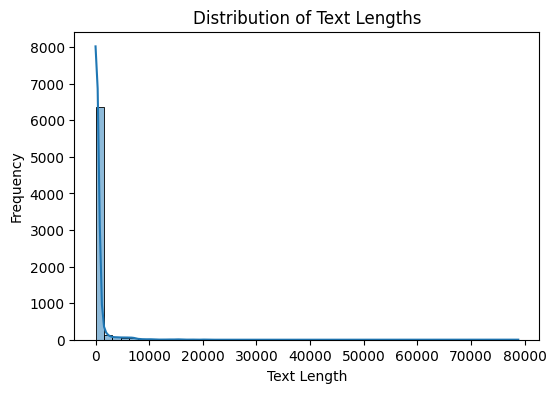

In [7]:
# Load the dataset
file_path = '/Users/baroski/Documents/Cursor/information_retrieval/v2/datasets/clinton_emails/clinton_emails.csv'
clinton_emails = pd.read_csv(file_path)

# Filter rows where "ExtractedBodyText" is not null
clinton_emails = clinton_emails[clinton_emails['ExtractedBodyText'].notna()]

extracted_body_stats = {
    "Total Messages with Text": len(clinton_emails),
    "Average Text Length": clinton_emails['ExtractedBodyText'].str.len().mean(),
    "Max Text Length": clinton_emails['ExtractedBodyText'].str.len().max(),
    "Min Text Length": clinton_emails['ExtractedBodyText'].str.len().min(),
}

# create cleaned text column
clinton_emails['CleanedText'] = clinton_emails['ExtractedBodyText'].apply(preprocess_body_text)
clinton_emails.to_csv(general_path + 'datasets/clinton_emails/clinton_emails_cleaned.csv', index=False)

# Plot the distribution of text lengths
plt.figure(figsize=(6, 4))
sns.histplot(clinton_emails['ExtractedBodyText'].str.len(), bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [5]:
#load from csv
clinton_emails = pd.read_csv(general_path + 'datasets/clinton_emails/clinton_emails_cleaned.csv')

## Enron emails

The Enron email dataset contains approximately 500,000 emails generated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse.

In this dataset, the emails are stored in a CSV file with the following columns:
- file: the name of the email file
- message: the email message with from, to, cc, date, "body" that starts after a \n

this type of dataset makes it easy to extract the structural elements with regex expressions.

In [4]:
file_path = '/Users/baroski/Documents/Cursor/information_retrieval/v2/datasets/enron_emails/enron_emails.csv'
enron_emails = pd.read_csv(file_path)

In [5]:
enron_emails.head(5)

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [ ]:
# Apply the function to the 'message' column of the DataFrame
enron_emails[['from', 'to', 'cc', 'subject', 'CleanedText']] = enron_emails['message'].progress_apply(
    lambda x: pd.Series(preprocess_enron_df(x))
)
# Drop rows where 'CleanedText' is empty
enron_emails = enron_emails[enron_emails['CleanedText'].str.strip().astype(bool)]
enron_emails.to_csv(general_path + 'datasets/enron_emails/enron_emails_cleaned.csv', index=False)

In [7]:
# load from csv
enron_emails = pd.read_csv(general_path + 'datasets/enron_emails/enron_emails_cleaned.csv')

In [6]:
enron_emails.head(5)

,file,message,from,to,cc,subject,CleanedText,LdaText
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,phillip.allen@enron.com,tim.belden@enron.com,NaN,NaN,here is our forecast,forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,phillip.allen@enron.com,john.lavorato@enron.com,NaN,NaN,traveling to have business meeting takes the f...,traveling business meeting takes fun trip espe...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,phillip.allen@enron.com,leah.arsdall@enron.com,NaN,test,test successful way to go,test successful way
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,phillip.allen@enron.com,randall.gay@enron.com,NaN,NaN,randy can you send me schedule of the salary a...,randy send schedule salary level everyone sche...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,phillip.allen@enron.com,greg.piper@enron.com,NaN,hello,lets shoot for tuesday at,lets shoot tuesday


## Fraudolent emails

Fraudulent e-mails contain criminally deceptive information, usually with the intent of convincing the recipient to give the sender a large amount of money. Perhaps the best known type of fraudulent e-mails is the Nigerian Letter or “419” Fraud.

This dataset is a collection of more than 2,500 "Nigerian" Fraud Letters, dating from 1998 to 2007.

These emails are in a single text file.

In [8]:
with open(general_path + "datasets/fraudolent_emails/fraudolent_emails.txt", "r", encoding="ISO-8859-1") as file:
    fraudolent_emails_text = file.read()

fraudolent_emails = preprocess_fraudolent_emails(fraudolent_emails_text)
fraudolent_emails.to_csv(general_path + 'datasets/fraudolent_emails/fraudolent_emails_cleaned.csv', index=False)

In [9]:
# load from csv
fraudolent_emails = pd.read_csv(general_path + 'datasets/fraudolent_emails/fraudolent_emails_cleaned.csv')
fraudolent_emails.rename(columns={'body': 'CleanedText'}, inplace=True)


In [10]:
fraudolent_emails.head(5)

,from,to,date,subject,CleanedText
0,"""MR. JAMES NGOLA."" <james_ngola2002@maktoob.com>",james_ngola2002@maktoob.com,"Thu, 31 Oct 2002 02:38:20 +0000",urgent business assistance and partnership,frommr james ngola confidential tel email urge...
1,"""Mr. Ben Suleman"" <bensul2004nng@spinfinder.com>",R@M,"Thu, 31 Oct 2002 05:10:00",urgent assistance lationship,dear friend am mr ben suleman custom officer a...
2,"""PRINCE OBONG ELEME"" <obong_715@epatra.com>",obong_715@epatra.com,"Thu, 31 Oct 2002 22:17:55 +0100",good day to you,from his royal majesty hrm crown ruler of elem...
3,"""PRINCE OBONG ELEME"" <obong_715@epatra.com>",webmaster@aclweb.org,"Thu, 31 Oct 2002 22:44:20",good day to you,from his royal majesty hrm crown ruler of elem...
4,"""Maryam Abacha"" <m_abacha03@www.com>",m_abacha03@www.com,"Fri, 1 Nov 2002 01:45:04 +0100",need your assistance,dear sir it is with heart full of hope that wr...


## NPS chat


The NPS Chat Corpus is a dataset consisting of over 10,000 messages collected from online chat rooms organized by age groups. It was created in 2007 by Eric Forsyth, Jane Lin, and Craig Martell from the Department of Computer Science at the Naval Postgraduate School. (bond-lab.github.io)

This corpus was developed to support research in the field of Natural Language Processing (NLP) and dialogue analysis. The messages in the corpus have been anonymized to protect users' privacy and are tagged with part-of-speech (POS) labels using the Penn Treebank. Additionally, the corpus includes dialogue act annotations to facilitate the analysis of interactions. (nltk.org)

The NPS Chat Corpus is available as part of the Natural Language Toolkit (NLTK), a widely used Python library for NLP applications. It is important to note that this corpus is distributed exclusively for educational, non-commercial, and non-profit research purposes. (kaggle.com)

In [2]:
# we need to merge and parse all the xml files
all_data = []
for file_name in os.listdir(general_path + 'datasets/nps_chat'):
    if file_name.endswith(".xml"):
        file_path = os.path.join(general_path + 'datasets/nps_chat', file_name)
        all_data.extend(parse_xml(file_path))

# Create a DataFrame
nps_chat = pd.DataFrame(all_data)
nps_chat.to_csv(general_path + 'datasets/nps_chat/nps_chat_cleaned.csv', index=False)
nps_chat.head(5)

,File,User,Class,Content,Tokens,WordCount,FirstWord,LastWord
0,10-24-40s_706posts.xml,10-24-40sUser20,Bye,tc 10-24-40sUser9,"[(tc, UH), (10-24-40sUser9, NNP)]",2,tc,10-24-40sUser9
1,10-24-40s_706posts.xml,10-24-40sUser24,Statement,"Tell me why after all this time ,do you hide ,...","[(Tell, VB), (me, PRP), (why, WRB), (after, IN...",21,Tell,",,,"
2,10-24-40s_706posts.xml,10-24-40sUser11,Greet,hi 10-24-40sUser8,"[(hi, UH), (10-24-40sUser8, NNP)]",2,hi,10-24-40sUser8
3,10-24-40s_706posts.xml,10-24-40sUser10,Emphasis,omg! I bet u were upset 10-24-40sUser28!,"[(omg, UH), (!, .), (I, PRP), (bet, VBP), (u, ...",9,omg,!
4,10-24-40s_706posts.xml,10-24-40sUser17,Emotion,yikes 10-24-40sUser28,"[(yikes, UH), (10-24-40sUser28, NNP)]",2,yikes,10-24-40sUser28


In [10]:
# load from csv
nps_chat = pd.read_csv(general_path + 'datasets/nps_chat/nps_chat_cleaned.csv')
nps_chat.rename(columns={'Content': 'CleanedText'}, inplace=True)
nps_chat.head(5)

,File,User,Class,CleanedText,Tokens,WordCount,FirstWord,LastWord
0,10-24-40s_706posts.xml,10-24-40sUser20,Bye,tc 10-24-40sUser9,"[('tc', 'UH'), ('10-24-40sUser9', 'NNP')]",2,tc,10-24-40sUser9
1,10-24-40s_706posts.xml,10-24-40sUser24,Statement,"Tell me why after all this time ,do you hide ,...","[('Tell', 'VB'), ('me', 'PRP'), ('why', 'WRB')...",21,Tell,",,,"
2,10-24-40s_706posts.xml,10-24-40sUser11,Greet,hi 10-24-40sUser8,"[('hi', 'UH'), ('10-24-40sUser8', 'NNP')]",2,hi,10-24-40sUser8
3,10-24-40s_706posts.xml,10-24-40sUser10,Emphasis,omg! I bet u were upset 10-24-40sUser28!,"[('omg', 'UH'), ('!', '.'), ('I', 'PRP'), ('be...",9,omg,!
4,10-24-40s_706posts.xml,10-24-40sUser17,Emotion,yikes 10-24-40sUser28,"[('yikes', 'UH'), ('10-24-40sUser28', 'NNP')]",2,yikes,10-24-40sUser28


# Structural elements extraction


## Spacy

In [31]:
# # Download english model
# nlp = spacy.load("en_core_web_sm")

In [36]:
# # Define a function to extract structural elements dynamically
# def extract_structural_elements_spacy(text):
#     doc = nlp(text)
#     structural_elements = {"Greeting": None, "Signature": None}
    
#     # Extract greeting: look for the first sentence with a high presence of proper nouns or polite phrases
#     for sent in doc.sents:
#         if any(token.pos_ in ["PROPN", "PRON", "NOUN"] for token in sent) and any(token.text.lower() in ["dear", "hi", "hello", "greetings", "good"] for token in sent):
#             structural_elements["Greeting"] = sent.text.strip()
#             break
    
#     # Extract signature: look for proper nouns and roles in the last sentence(s)
#     sentences = list(doc.sents)
#     if sentences:  # Check if there are any sentences
#         last_sentence = sentences[-1]
#         if any(token.ent_type_ == "PERSON" for token in last_sentence):
#             structural_elements["Signature"] = last_sentence.text.strip()
    
#     return structural_elements

# # Apply the extraction function to the cleaned text

# filtered_data["StructuralElements"] = filtered_data["CleanedText"].progress_apply(extract_structural_elements_spacy)

# # Preview the extracted structural elements
# print(filtered_data[["Id", "CleanedText", "StructuralElements"]].head())

  0%|          | 0/6742 [00:00<?, ?it/s]

100%|██████████| 6742/6742 [03:50<00:00, 29.23it/s]

   Id                                        CleanedText  \
1   2  b6 thursday march 3 2011 latest how syria is a...   
2   3                                                thx   
4   5  friday march 11 2011 huma abedin fw latest how...   
5   6  pis print wednesday september 12 2012 fw meet ...   
7   8  friday march 11 2011 huma abedin fw latest how...   

                                  StructuralElements  
1  {'Greeting': None, 'Signature': 'more sid hrc ...  
2              {'Greeting': None, 'Signature': None}  
4  {'Greeting': None, 'Signature': 'friday march ...  
5              {'Greeting': None, 'Signature': None}  
7  {'Greeting': None, 'Signature': 'friday march ...  


# Non-structural elements extraction


In [ ]:
#Topic extraction

## Topic recognition

### Enron emails

In [ ]:
# Prepare dataset for LDA
# What is LDA? Latent Dirichlet Allocation is a topic modeling technique that uses a 
# probabilistic approach to identify topics in a corpus of text. 

In [25]:
def preprocess_text_for_lda(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english') and len(word) > 2]
    # Lemmatize the tokens (skip for now)
    # lemmatizer = WordNetLemmatizer()
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Filter short tokens
    #tokens = [word for word in tokens if len(word) > 2]
    # Join tokens back to a string 
    return " ".join(tokens)

# filtered_data['LdaText'] = filtered_data['ExtractedBodyText'].progress_apply(preprocess_text_for_lda)
# print(filtered_data[['Id', 'LdaText']])


In [26]:
# done
# enron_emails['LdaText'] = enron_emails['CleanedText'].progress_apply(preprocess_text_for_lda)

100%|██████████| 515974/515974 [1:07:44<00:00, 126.93it/s] 


In [27]:
# enron_emails.to_csv(general_path + 'datasets/enron_emails/enron_emails_cleaned.csv', index=False)

In [5]:
enron_emails = pd.read_csv(general_path + 'datasets/enron_emails/enron_emails_cleaned.csv')
enron_emails.head(5)

,file,message,from,to,cc,subject,CleanedText,LdaText
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,phillip.allen@enron.com,tim.belden@enron.com,NaN,NaN,here is our forecast,forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,phillip.allen@enron.com,john.lavorato@enron.com,NaN,NaN,traveling to have business meeting takes the f...,traveling business meeting takes fun trip espe...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,phillip.allen@enron.com,leah.arsdall@enron.com,NaN,test,test successful way to go,test successful way
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,phillip.allen@enron.com,randall.gay@enron.com,NaN,NaN,randy can you send me schedule of the salary a...,randy send schedule salary level everyone sche...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,phillip.allen@enron.com,greg.piper@enron.com,NaN,hello,lets shoot for tuesday at,lets shoot tuesday


#### LDA (scikit-learn)

##### Run

In [7]:
# Run with preprocess (no lemmatization)
# I'm using the pre-built LDA text column, dropping eventual null values
start_time = time.time()
texts = enron_emails['LdaText'].sample(n=100000,random_state=42).dropna().tolist()
print('list of texts created')

### LDA ###
# Step 1: Convert text to bag-of-words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(texts)
print('dtm created')

# Step 2: Measure execution time for LDA with progress tracking
n_components = 3
lda = LatentDirichletAllocation(n_components=n_components, random_state=42, max_iter=10, learning_method='online')
print('lda initialized')

# Initialize the progress bar
with tqdm(total=lda.max_iter, desc="Fitting LDA", unit="iteration") as pbar:
    for i in range(lda.max_iter):
        lda.partial_fit(dtm)
        pbar.update(1)
        
print('lda fitted')

lda_time = time.time() - start_time

# Step 3: Extract topics and evaluate coherence
lda_topics = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]] for topic in lda.components_]
dictionary = Dictionary([text.split() for text in texts])
corpus = [dictionary.doc2bow(text.split()) for text in texts]
lda_coherence = CoherenceModel(topics=lda_topics, texts=[text.split() for text in texts], dictionary=dictionary, coherence='c_v').get_coherence()

print(f"LDA Execution Time: {lda_time:.2f}s")
print(f"LDA Coherence Score: {lda_coherence:.4f}")
print(f"LDA Topics:")
for topic in lda_topics:
    print("Topic n " + str(lda_topics.index(topic)) + ": " + str(topic))


list of texts created
dtm created
lda initialized


Fitting LDA: 100%|██████████| 10/10 [03:01<00:00, 18.17s/iteration]


lda fitted
LDA Execution Time: 185.86s
LDA Coherence Score: 0.6253
LDA Topics:
Topic n 0: ['email', 'subject', 'message', '2001', 'sent', 'know', 'time', 'image', 'like', 'free']
Topic n 1: ['subject', 'enron', 'thanks', 'message', 'email', 'sent', 'know', 'forwarded', '2001', 'attached']
Topic n 2: ['power', 'energy', 'enron', 'said', 'company', 'new', 'market', 'california', 'state', 'gas']


In [8]:
# More stats
# Calculate Perplexity
perplexity = lda.perplexity(dtm)

# Calculate Topic Diversity
def calculate_topic_diversity(topics):
    unique_words = set()
    total_words = 0
    for topic in topics:
        unique_words.update(topic)
        total_words += len(topic)
    return len(unique_words) / total_words

topic_diversity = calculate_topic_diversity(lda_topics)

# Print Statistics
print(f"LDA Execution Time: {lda_time:.2f}s")
print(f"LDA Coherence Score: {lda_coherence:.4f}")
print(f"LDA Perplexity: {perplexity:.4f}")
print(f"Topic Diversity: {topic_diversity:.4f}")
print(f"LDA Topics:")
for topic in lda_topics:
    print("Topic n " + str(lda_topics.index(topic)) + ": " + str(topic))

LDA Execution Time: 185.86s
LDA Coherence Score: 0.6253
LDA Perplexity: 6188.9186
Topic Diversity: 0.7667
LDA Topics:
Topic n 0: ['email', 'subject', 'message', '2001', 'sent', 'know', 'time', 'image', 'like', 'free']
Topic n 1: ['subject', 'enron', 'thanks', 'message', 'email', 'sent', 'know', 'forwarded', '2001', 'attached']
Topic n 2: ['power', 'energy', 'enron', 'said', 'company', 'new', 'market', 'california', 'state', 'gas']


In [18]:
# Save the LDA model, topics, and metrics
save_lda_model(
    dataset="enron_emails",
    output_folder="./run_results/lda",
    lda=lda,
    lda_topics=lda_topics,
    lda_coherence=lda_coherence,
    perplexity=perplexity,
    topic_diversity=topic_diversity,
    lda_time=lda_time
)

Modello LDA salvato in: ./run_results/lda/enron_emails/models/lda_model.pkl
Topic salvati in: ./run_results/lda/enron_emails/topics/lda_topics.json
Metriche salvate in: ./run_results/lda/enron_emails/metrics/lda_metrics.json


In [2]:
# lda, lda_topics, lda_metrics = load_lda_model(
#     dataset="enron_emails",
#     output_folder="./run_results/lda",
# )

Output folder: ./run_results/lda/enron_emails


##### Visualization

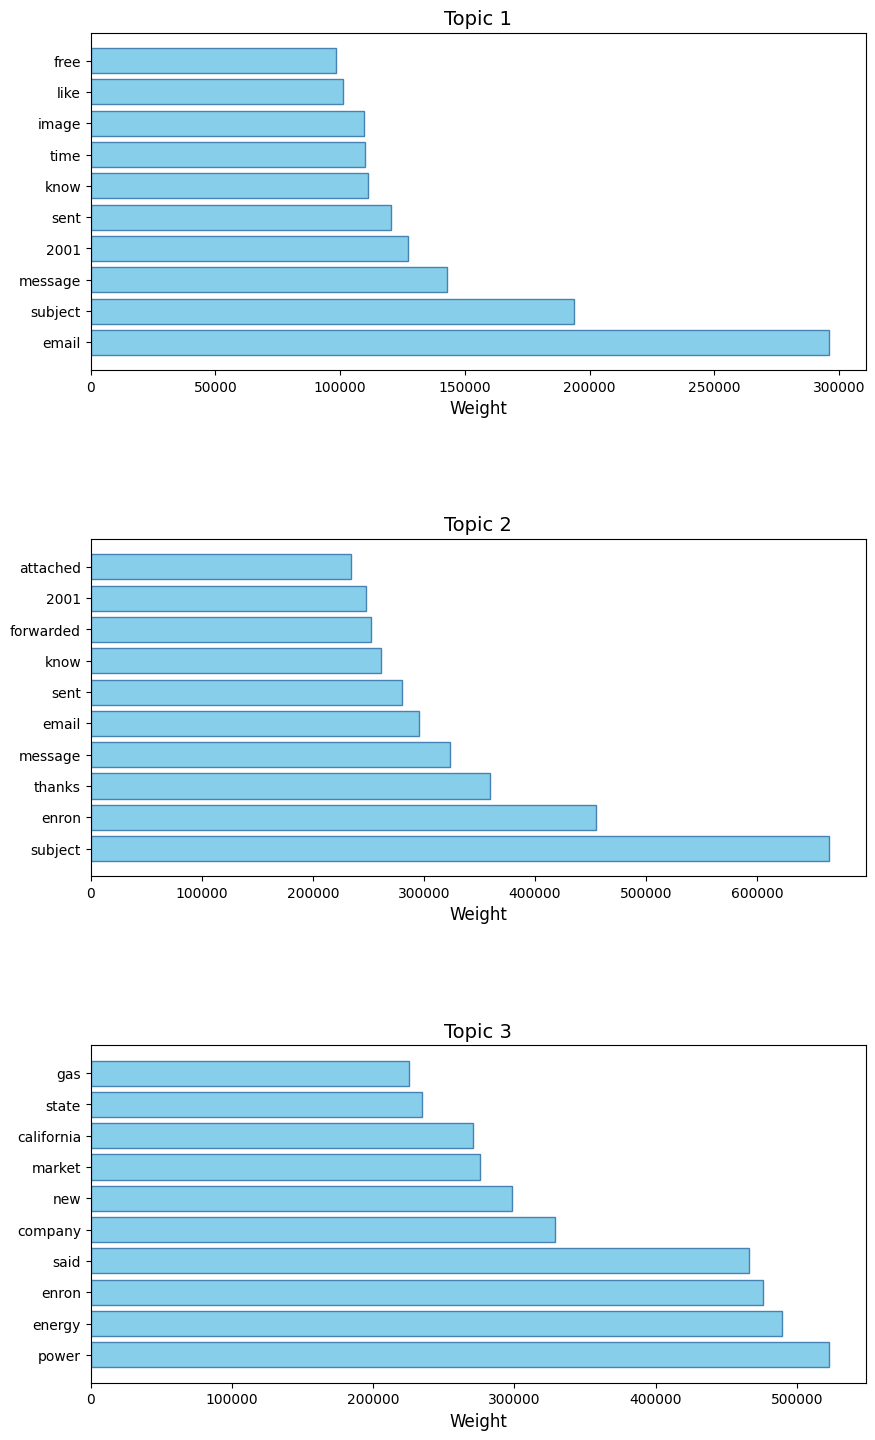

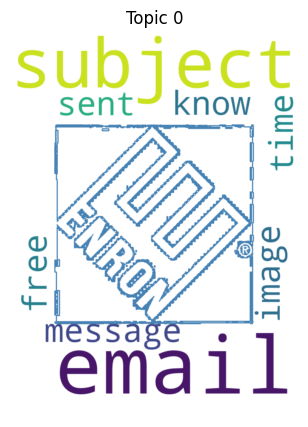

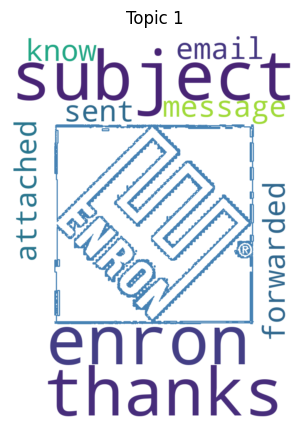

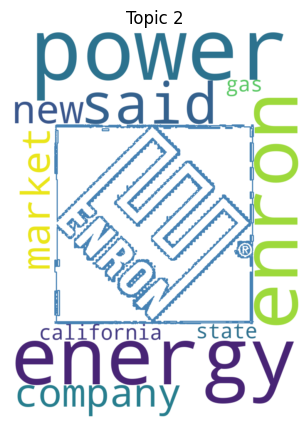

In [20]:
# Plot results
def plot_top_words(lda, feature_names, n_top_words, n_components):
    fig, axes = plt.subplots(n_components, 1, figsize=(10, 15), sharex=False)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='skyblue', edgecolor='steelblue')
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 14})
        ax.tick_params(axis='x', which='major', labelsize=10)
        ax.tick_params(axis='y', which='major', labelsize=10)
        ax.set_xlabel('Weight', fontsize=12)
    
    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.3, hspace=0.5)
    plt.show()

plot_top_words(lda, vectorizer.get_feature_names_out(), 10, n_components)

def generate_wordclouds_with_mask(lda_topics, mask_image_path):
    """
    Generate word clouds for each topic using a custom mask image.

    :param lda_topics: List of topics, where each topic is a list of words.
    :param mask_image_path: Path to the custom mask image (e.g., a PNG file).
    :param output_folder: Folder to save the generated word clouds.
    """
    # Load the mask image and convert it to a numpy array
    mask = np.array(Image.open(mask_image_path))

    # Generate a word cloud for each topic
    for i, topic in enumerate(lda_topics):
        # Combine the words in the topic into a single string
        text = " ".join(topic)

        # Create a WordCloud object with the custom mask
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            mask=mask,  # Use the custom mask
            stopwords=STOPWORDS,  # Use default stopwords
            contour_width=3,
            contour_color='steelblue'
        ).generate(text)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {i}")

generate_wordclouds_with_mask(lda_topics, "/Users/baroski/Documents/Cursor/information_retrieval/v2/src/img/enron.jpg")

In [ ]:
# # Word Clouds for each topic
# def plot_word_clouds(topics):
#     for i, topic in enumerate(topics):
#         wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(topic))
#         plt.figure(figsize=(10, 5))
#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis('off')
#         plt.title(f"Topic {i}")
#         plt.show()

# plot_word_clouds(lda_topics)

In [27]:
# # Run using default texts
# # Prepare data
# texts = filtered_data['LdaText'].tolist()

# ### LDA ###
# # Step 1: Convert text to bag-of-words
# vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
# dtm = vectorizer.fit_transform(texts)

# # Step 2: Measure execution time for LDA
# start_time = time.time()
# lda = LatentDirichletAllocation(n_components=5, random_state=42)
# lda.fit(dtm)

# lda_time = time.time() - start_time

# # Step 3: Extract topics and evaluate coherence
# lda_topics = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]] for topic in lda.components_]
# dictionary = Dictionary([text.split() for text in texts])
# corpus = [dictionary.doc2bow(text.split()) for text in texts]
# lda_coherence = CoherenceModel(topics=lda_topics, texts=[text.split() for text in texts], dictionary=dictionary, coherence='c_v').get_coherence()

# print(f"LDA Execution Time: {lda_time:.2f}s")
# print(f"LDA Coherence Score: {lda_coherence:.4f}")
# print(f"LDA Topics:")
# for topic in lda_topics:
#     print("Topic n " + str(lda_topics.index(topic)) + ": " + str(topic))




LDA Execution Time: 5.98s
LDA Coherence Score: 0.5827
LDA Topics:
Topic n 0: ['said', 'obama', 'president', 'new', 'mr', 'american', 'house', 'state', 'political', 'policy']
Topic n 1: ['fyi', 'just', 'good', 'china', 'think', 'know', 'work', 'like', 'people', 'did']
Topic n 2: ['2010', 'cheryl', 'women', 'mills', '2009', 'fw', 'print', 'pls', 'said', 'people']
Topic n 3: ['office', 'secretarys', 'meeting', 'state', 'room', 'department', 'time', 'arrive', 'en', 'route']
Topic n 4: ['state', '2009', 'benghazi', 'subject', 'department', 'agreement', 'case', 'information', 'doc', 'date']


In [11]:
# topics = lda.print_topics(num_topics=5, num_words=10)
# for i, topic in enumerate(topics):
#     print(f"Topic {i}: {topic}")

AttributeError: 'LatentDirichletAllocation' object has no attribute 'print_topics'

### BERTopic

In [16]:
#  select texts for BERT
bertopic_texts = enron_emails['CleanedText'].sample(n=100000,random_state=42).dropna().tolist()
# Initialize BERTopic
bertopic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

# Fit the model on the preprocessed texts
topics, probabilities = bertopic_model.fit_transform(bertopic_texts)

2025-01-26 16:20:44,493 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

2025-01-26 16:28:59,503 - BERTopic - Embedding - Completed ✓
2025-01-26 16:28:59,504 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-01-26 16:29:51,571 - BERTopic - Dimensionality - Completed ✓
2025-01-26 16:29:51,572 - BERTopic - Cluster - Start clustering the reduced embeddings


In [ ]:
# Get the topics and their top words
bertopic_topics = bertopic_model.get_topics()

# Print the topics
for topic_id, words in bertopic_topics.items():
    print(f"Topic {topic_id}: {words}")

In [ ]:
# Visualize the topics
bertopic_model.visualize_topics()
# Visualize the topic hierarchy
bertopic_model.visualize_hierarchy()
# Visualize the top words for each topic
bertopic_model.visualize_barchart()

In [14]:
# cassato - fare bertopic
def generate_bert_embeddings(texts, tokenizer, model, max_length=128):
    """
    Generate BERT embeddings for a list of texts.
    """
    embeddings = []
    for text in texts:
        # Tokenize the text
        inputs = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length')
        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the [CLS] token embedding as the document embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)
    return np.array(embeddings)

# Generate BERT embeddings
bert_embeddings = generate_bert_embeddings(bert_texts, tokenizer, model)
print(f"BERT embeddings shape: {bert_embeddings.shape}")

KeyboardInterrupt: 

In [28]:
def preprocess_text_for_bertopic(text):
    # Minimal preprocessing
    text = re.sub(r'\S+@\S+', '', text)        
    text = re.sub(r'http\S+|www.\S+', '', text) 
    
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Filter short tokens
    # tokens = [word for word in tokens if len(word) > 2]
    # Join tokens back to a string 
    # return " ".join(tokens)
    return text
bertopic_texts = filtered_data.copy()
bertopic_texts['CleanedText'] = bertopic_texts['CleanedText'].progress_apply(preprocess_text_for_bertopic)
print(bertopic_texts)

100%|██████████| 6742/6742 [00:00<00:00, 46837.57it/s]

        Id                                        CleanedText
1        2  b6 thursday march 3 2011 latest how syria is a...
2        3                                                thx
4        5  friday march 11 2011 huma abedin fw latest how...
5        6  pis print wednesday september 12 2012 fw meet ...
7        8  friday march 11 2011 huma abedin fw latest how...
...    ...                                                ...
7938  7939  hi sorry havent had chance to see you but did ...
7939  7940  b6 assume you saw this by now if not its worth...
7941  7942  big change of plans in the senate senator reid...
7943  7944  pverveer b6 friday december 17 2010 from b6 pl...
7944  7945                                          see below

[6742 rows x 2 columns]


In [31]:
# Fit BERTopic model
start_time = time.time()
bertopic_model = BERTopic(min_topic_size=50)
topics, probs = bertopic_model.fit_transform(bertopic_texts['CleanedText'])
bertopic_time = time.time() - start_time

# Get topic information
topic_info = bertopic_model.get_topic_info()
topics_dict = bertopic_model.get_topics()


print(f"BERTopic Execution Time: {bertopic_time:.2f}s")
print("\nTop 10 Most Representative Topics:")
# Get top 10 topics by size (excluding -1 which represents outliers)
top_topics = topic_info[topic_info['Topic'] != -1].head(10)
for _, row in top_topics.iterrows():
    topic_id = row['Topic']
    words = [word for word, _ in bertopic_model.get_topic(topic_id)][:10]
    size = row['Count']
    print(f"Topic {topic_id} (Size: {size}): {words}")

# Visualize only top 10 topics
fig = bertopic_model.visualize_topics(top_n_topics=10)

# Coherence calculation
topic_words = []
for topic_id, word_score_pairs in topics_dict.items():
    if topic_id != -1:  # Exclude outliers
        words = [word for word, _ in word_score_pairs]
        topic_words.append(words)

if topic_words:  
    dictionary = Dictionary([text.split() for text in filtered_data['CleanedText']])
    corpus = [dictionary.doc2bow(text.split()) for text in filtered_data['CleanedText']]
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=[text.split() for text in filtered_data['CleanedText']],
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    print(f"\nBERTopic Coherence Score: {coherence_score:.4f}")

BERTopic Execution Time: 14.19s

Top 10 Most Representative Topics:
Topic 0 (Size: 1238): ['you', 'call', 'can', 'do', 'will', 'to', 'we', 'him', 'talk', 'me']
Topic 1 (Size: 464): ['fyi', 'this', 'you', 'below', 'info', 'good', 'we', 'mpcsapp', 'ffyi', 'cir']
Topic 2 (Size: 271): ['cheryl', 'mills', 'fw', '2009', 'fyi', '2010', 're', 'sullivan', 'jacob', 'friday']
Topic 3 (Size: 194): ['re', '2010', 'sullivan', 'jacob', '2009', 'sunday', 'hillary', 'saturday', 'fw', 'october']
Topic 4 (Size: 187): ['her', 'she', 'you', 'will', 'to', 'lona', 'can', 'huma', 'shes', 'lauren']
Topic 5 (Size: 152): ['haiti', 'and', 'the', 'to', 'in', 'of', 'for', 'on', 'with', 'we']
Topic 6 (Size: 134): ['ok', 'me', 'stopping', 'gheit', 'thru', 'necessary', 'put', 'im', 'just', 'not']
Topic 7 (Size: 127): ['email', 'please', 'you', 'assistance', 'need', 'immediate', 'if', 'access', 'am', 'contact']
Topic 8 (Size: 111): ['the', 'of', 'in', 'and', 'to', 'that', 'his', 'for', 'he', 'as']
Topic 9 (Size: 109): 

## NER (named entity recognition)

### Spacy


In [ ]:
# 1. Approach with spaCy
nlp = spacy.load("en_core_web_sm")

def extract_entities_spacy(text):
    doc = nlp(text)
    entities = []
    
    for ent in doc.ents:
        entities.append({
            'text': ent.text,
            'label': ent.label_,
            'start': ent.start_char,
            'end': ent.end_char
        })
    
    return entities

# Extract entities from the entire dataset
results_spacy = []
for idx, row in tqdm(filtered_data.iterrows(), total=len(filtered_data), desc="Processing with spaCy"):
    entities = extract_entities_spacy(row['CleanedText'])
    for ent in entities:
        results_spacy.append({
            'doc_id': row['Id'],
            'entity': ent['text'],
            'type': ent['label']
        })

# Create DataFrame with results
df_entities_spacy = pd.DataFrame(results_spacy)

# Analysis of entities found
print("\nAnalysis of entities found with spaCy:")
print("\nDistribution of entity types:")
print(df_entities_spacy['type'].value_counts())

print("\nExamples for each major type of entity:")
for ent_type in df_entities_spacy['type'].value_counts().head(10).index:
    print(f"\n{ent_type} (top 5 most frequent):")
    print(df_entities_spacy[df_entities_spacy['type'] == ent_type]['entity'].value_counts().head(5))

# Salva i risultati
df_entities_spacy.to_csv('spacy_ner_results.csv', index=False)

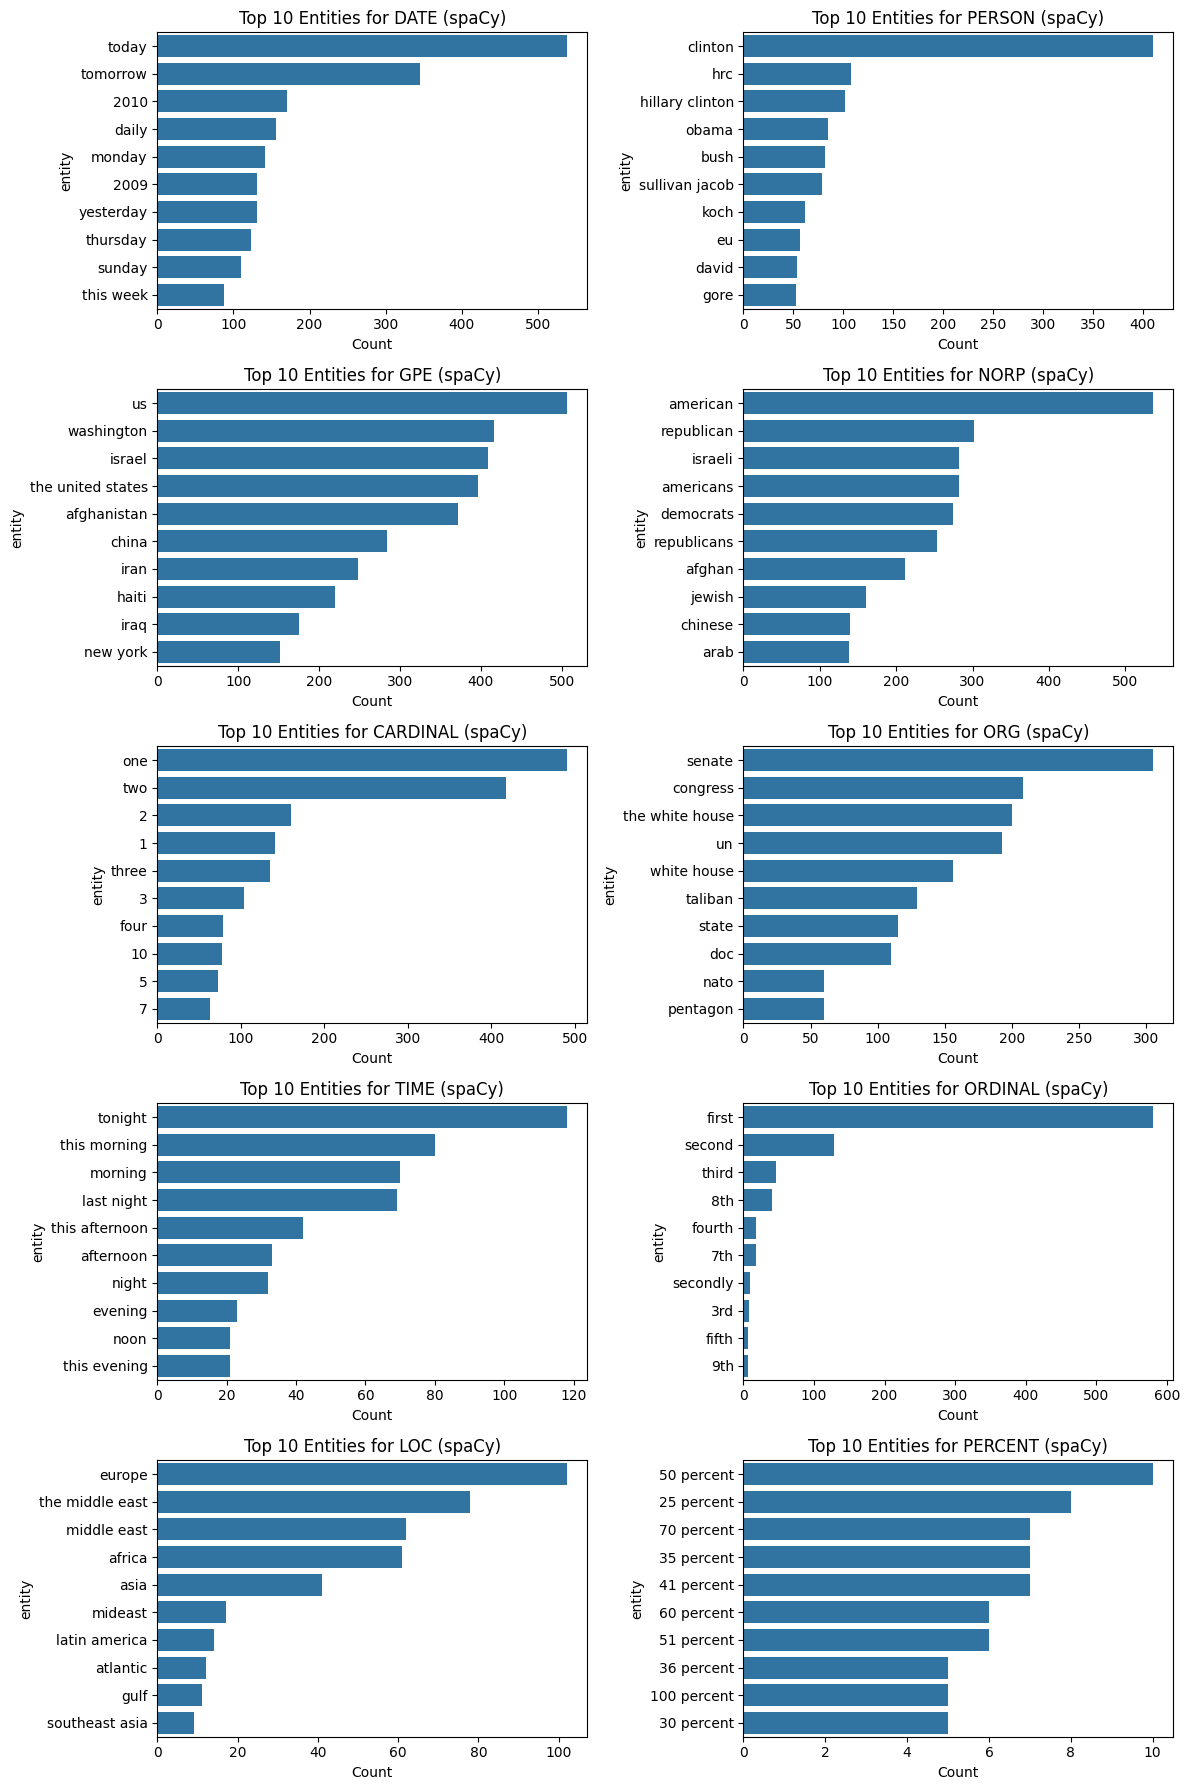

In [38]:
# Top entities for each type
plt.figure(figsize=(12, 18))
top_entity_types = df_entities_spacy['type'].value_counts().head(10).index

for i, ent_type in enumerate(top_entity_types, 1):
    plt.subplot(5, 2, i)
    sns.barplot(x=df_entities_spacy[df_entities_spacy['type'] == ent_type]['entity'].value_counts().head(10).values, 
                y=df_entities_spacy[df_entities_spacy['type'] == ent_type]['entity'].value_counts().head(10).index)
    plt.title(f'Top 10 Entities for {ent_type} (spaCy)')
    plt.xlabel('Count')
    plt.tight_layout()

plt.show()

### Bert v1(#)

In [71]:
# 2. Approach with Transformers
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

def extract_entities_transformer(text):
    # Handles the maximum length of text for BERT
    max_length = 512
    if len(text) > max_length:
        text = text[:max_length]
    
    try:
        entities = ner_pipeline(text)
        return entities
    except Exception as e:
        print(f"Error processing text: {e}")
        return []

# Process the entire dataset
results_transformer = []
for idx, row in tqdm(filtered_data.iterrows(), total=len(filtered_data), desc="Processing with BERT"):
    entities = extract_entities_transformer(row['CleanedText'])
    for ent in entities:
        results_transformer.append({
            'doc_id': row['Id'],
            'entity': ent['word'],
            'type': ent['entity'],
            'score': ent['score']
        })

# Create DataFrame with results
df_entities_transformer = pd.DataFrame(results_transformer)

# Analysis of results
print("\nAnalysis of entities found with BERT:")
print("\nDistribution of entity types:")
print(df_entities_transformer['type'].value_counts())

print("\nExamples of entities with high confidence (score > 0.9):")
high_conf = df_entities_transformer[df_entities_transformer['score'] > 0.9]
for ent_type in high_conf['type'].value_counts().head(10).index:
    print(f"\n{ent_type} (top 5 most frequent):")
    print(high_conf[high_conf['type'] == ent_type]['entity'].value_counts().head(5))

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=df_entities_transformer['type'].value_counts().head(10).values,
            y=df_entities_transformer['type'].value_counts().head(10).index)
plt.title('Top 10 Entity Types (BERT)')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# Save results
df_entities_transformer.to_csv('v1_bert_ner_results.csv', index=False)


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0
Processing with BERT: 100%|██████████| 6742/6742 [03:38<00:00, 30.84it/s]


Analysis of entities found with BERT:

Distribution of entity types:
type
I-PER     1201
I-MISC    1067
I-LOC     1035
I-ORG      668
Name: count, dtype: int64

Examples of entities with high confidence (score > 0.9):

I-LOC (top 5 most frequent):
entity
##ghan     61
##istan    60
##azi      48
##gh       38
##stan     28
Name: count, dtype: int64

I-MISC (top 5 most frequent):
entity
##an      57
##eric    53
##ian     29
##uss     25
##ese     25
Name: count, dtype: int64

I-PER (top 5 most frequent):
entity
##ahu    10
c         9
ho        8
net       8
z         8
Name: count, dtype: int64

I-ORG (top 5 most frequent):
entity
al       4
j        3
##sar    2
##n      2
##ike    2
Name: count, dtype: int64


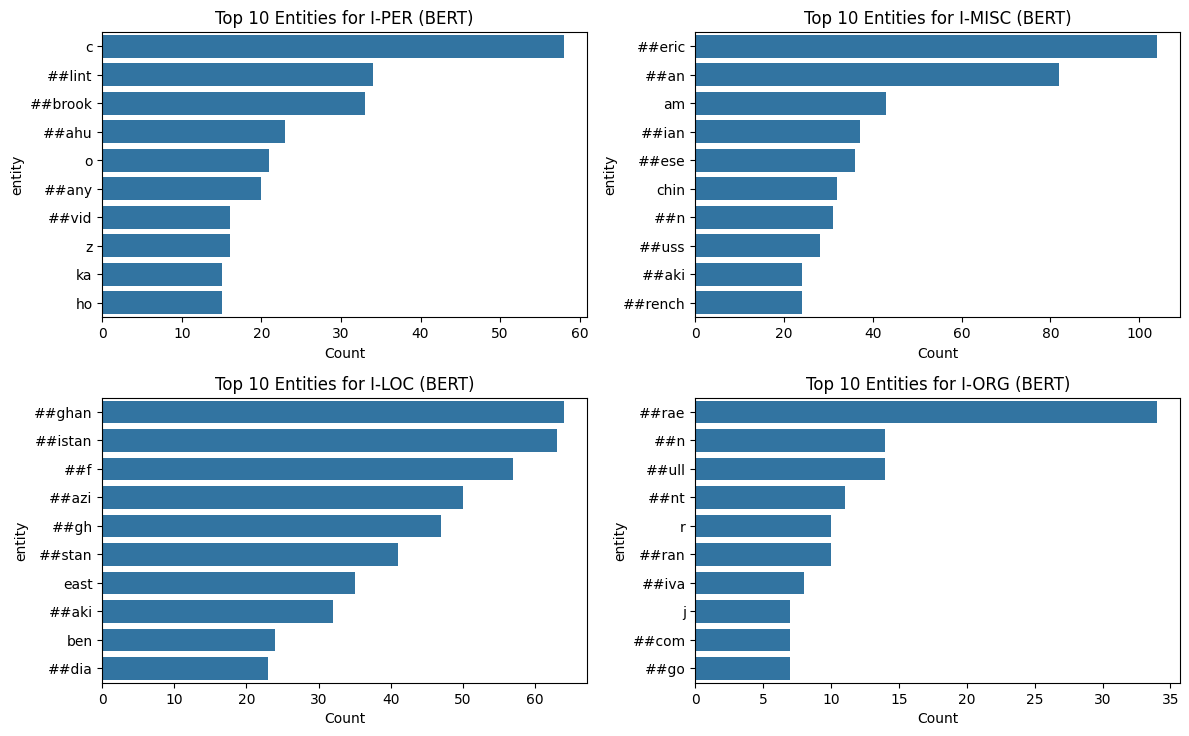

In [72]:
# Top entities for each type
plt.figure(figsize=(12, 18))
top_entity_types = df_entities_transformer['type'].value_counts().head(10).index

for i, ent_type in enumerate(top_entity_types, 1):
    plt.subplot(5, 2, i)
    sns.barplot(x=df_entities_transformer[df_entities_transformer['type'] == ent_type]['entity'].value_counts().head(10).values, 
                y=df_entities_transformer[df_entities_transformer['type'] == ent_type]['entity'].value_counts().head(10).index)
    plt.title(f'Top 10 Entities for {ent_type} (BERT)')
    plt.xlabel('Count')
    plt.tight_layout()

plt.show()

### Bert v2(#)

In [73]:
def extract_entities_transformer(text):
    # Handles the maximum length of text for BERT
    max_length = 512
    if len(text) > max_length:
        text = text[:max_length]
    
    try:
        entities = ner_pipeline(text)
        # Merge subword tokens and handle fragmentation
        merged_entities = []
        current_entity = ""
        current_label = None
        for ent in entities:
            word = ent['word']
            label = ent['entity']
            
            # Check if the word is a subtoken (starts with ##)
            if word.startswith("##"):
                current_entity += word[2:]  # Append the subtoken (without ##)
            else:
                # If a new entity starts, save the previous one
                if current_entity:
                    merged_entities.append({
                        'text': current_entity.strip(),
                        'label': current_label
                    })
                # Start a new entity
                current_entity = word
                current_label = label
        
        # Append the last entity if present
        if current_entity:
            merged_entities.append({
                'text': current_entity.strip(),
                'label': current_label
            })
        
        # Post-process merged entities to remove single-character entities
        clean_entities = [
            ent for ent in merged_entities 
            if len(ent['text']) > 1  # Filter out single-character entities
        ]
        
        return clean_entities
    except Exception as e:
        print(f"Error processing text: {e}")
        return []


# Process the entire dataset
results_transformer = []
for idx, row in tqdm(filtered_data.iterrows(), total=len(filtered_data), desc="Processing with BERT"):
    entities = extract_entities_transformer(row['CleanedText'])
    for ent in entities:
        results_transformer.append({
            'doc_id': row['Id'],
            'entity': ent['text'],
            'type': ent['label']
        })

# Create DataFrame with results
df_entities_transformer = pd.DataFrame(results_transformer)

# Analysis of results
print("\nAnalysis of entities found with BERT:")
print("\nDistribution of entity types:")
print(df_entities_transformer['type'].value_counts())

# print("\nExamples of entities with high confidence (score > 0.9):")
# high_conf = df_entities_transformer[df_entities_transformer['score'] > 0.9]
# for ent_type in high_conf['type'].value_counts().head(10).index:
#     print(f"\n{ent_type} (top 5 most frequent):")
#     print(high_conf[high_conf['type'] == ent_type]['entity'].value_counts().head(5))


# Save results
df_entities_transformer.to_csv('v2_bert_ner_results.csv', index=False)

Processing with BERT: 100%|██████████| 6742/6742 [04:11<00:00, 26.84it/s]


Analysis of entities found with BERT:

Distribution of entity types:
type
I-PER     368
I-MISC    230
I-LOC     215
I-ORG     142
Name: count, dtype: int64


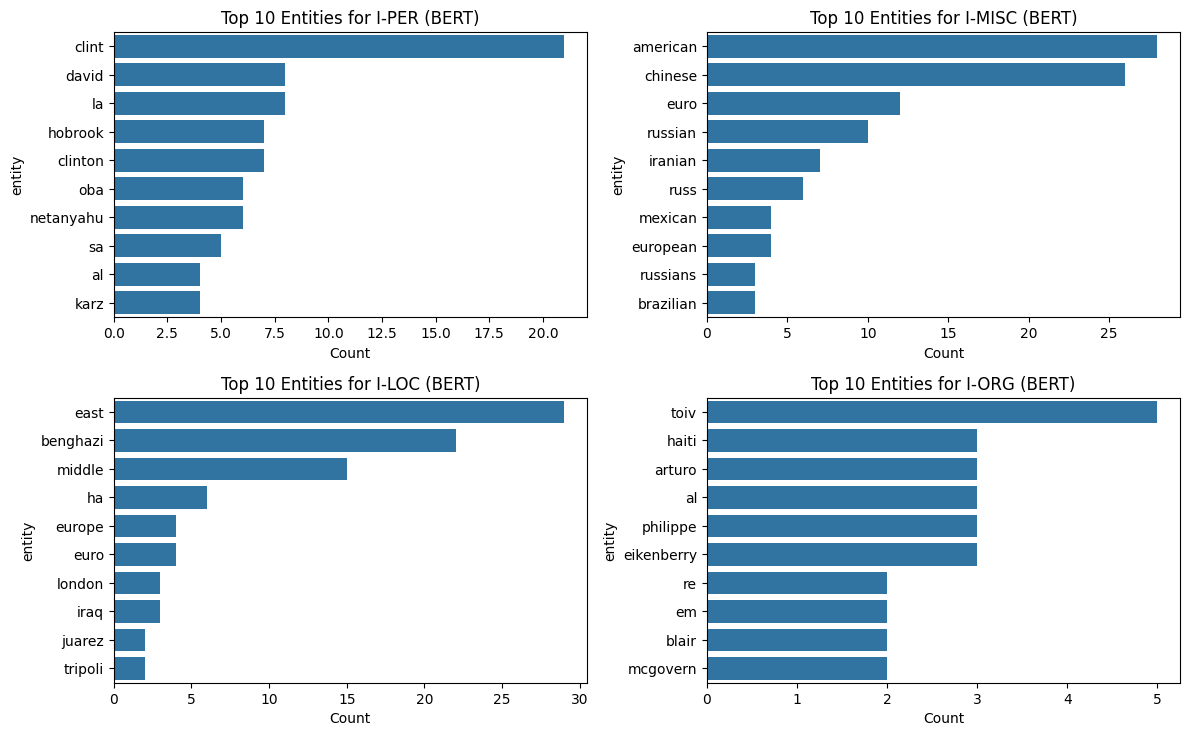

In [74]:
# Top entities for each type
plt.figure(figsize=(12, 18))
top_entity_types = df_entities_transformer['type'].value_counts().head(10).index

for i, ent_type in enumerate(top_entity_types, 1):
    plt.subplot(5, 2, i)
    sns.barplot(x=df_entities_transformer[df_entities_transformer['type'] == ent_type]['entity'].value_counts().head(10).values, 
                y=df_entities_transformer[df_entities_transformer['type'] == ent_type]['entity'].value_counts().head(10).index)
    plt.title(f'Top 10 Entities for {ent_type} (BERT)')
    plt.xlabel('Count')
    plt.tight_layout()

plt.show()

# Argument mining

## Spacy

In [9]:
nlp = spacy.load("en_core_web_sm")
# Function to extract argumentative phrases
def extract_arguments_spacy(text):
    doc = nlp(text)
    matcher = Matcher(nlp.vocab)
    
    # Define patterns for argumentative phrases
    patterns = [
        [{"POS": "PRON"}, {"POS": "VERB"}, {"POS": "DET", "OP": "?"}, {"POS": "NOUN"}],
        [{"POS": "ADV", "OP": "?"}, {"POS": "ADJ"}, {"POS": "VERB"}]
    ]
    matcher.add("ARGUMENT_PATTERN", patterns)
    
    matches = matcher(doc)
    arguments = []
    for match_id, start, end in matches:
        span = doc[start:end]
        arguments.append({
            'text': span.text,
            'start': span.start_char,
            'end': span.end_char
        })
    
    return arguments

# Apply extraction to the dataset
results_spacy = []
for idx, row in tqdm(filtered_data.iterrows(), total=len(filtered_data), desc="Processing with spaCy"):
    arguments = extract_arguments_spacy(row['CleanedText'])
    for arg in arguments:
        results_spacy.append({
            'doc_id': row['Id'],
            'argument': arg['text'],
            'start': arg['start'],
            'end': arg['end']
        })

# Create a DataFrame with the results
df_arguments_spacy = pd.DataFrame(results_spacy)

# Analysis of results
print("\nAnalysis of arguments found with spaCy:")
print(f"Total arguments found: {len(df_arguments_spacy)}")
print("\nExamples of arguments:")
print(df_arguments_spacy.head())

# Save results
df_arguments_spacy.to_csv('spacy_argument_results.csv', index=False)


Processing with spaCy: 100%|██████████| 6742/6742 [01:16<00:00, 88.11it/s] 


Analysis of arguments found with spaCy:
Total arguments found: 3213

Examples of arguments:
   doc_id                argument  start   end
0      14           you had heads    159   172
1      14          we have chance   1282  1296
2      14  we have an opportunity   2390  2412
3      14        they need action   5093  5109
4      14          least besieged   5332  5346


Total arguments found: 3213
Average argument length: 17.56 characters


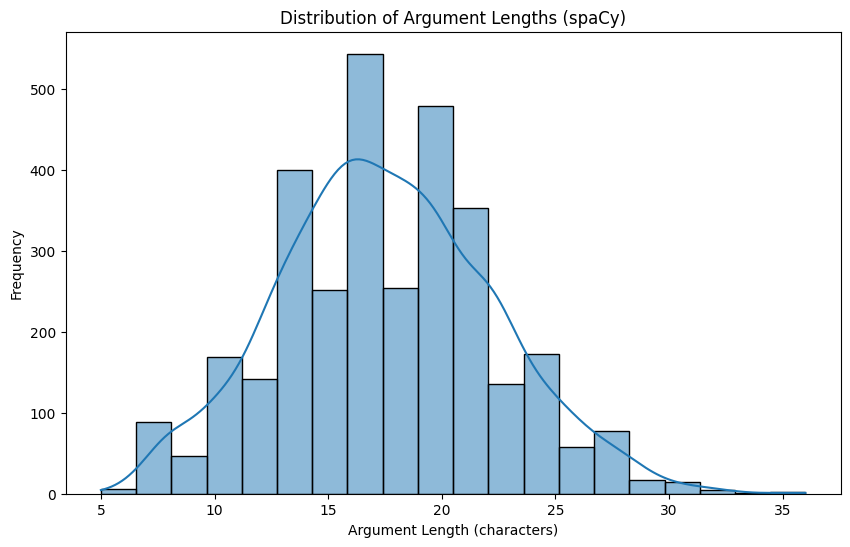

In [10]:
df_arguments_spacy = pd.read_csv('spacy_argument_results.csv')

# Remove rows with NaN values in the 'argument' column
df_arguments_spacy = df_arguments_spacy.dropna(subset=['argument'])

# Calculate statistics
total_arguments = len(df_arguments_spacy)
average_length = df_arguments_spacy['argument'].apply(len).mean()

print(f"Total arguments found: {total_arguments}")
print(f"Average argument length: {average_length:.2f} characters")

# Visualize the distribution of argument lengths
plt.figure(figsize=(10, 6))
sns.histplot(df_arguments_spacy['argument'].apply(len), bins=20, kde=True)
plt.title('Distribution of Argument Lengths (spaCy)')
plt.xlabel('Argument Length (characters)')
plt.ylabel('Frequency')
plt.show()

## Spacy v2

In [12]:
nlp = spacy.load("en_core_web_sm")

# Improved function to extract argumentative phrases
def extract_arguments_spacy_v2(text):
    doc = nlp(text)
    matcher = Matcher(nlp.vocab)
    
    # More extensive patterns to capture argumentative phrases
    patterns = [
        [{"POS": "PRON"}, {"POS": "VERB"}, {"POS": "DET", "OP": "?"}, {"POS": "NOUN", "OP": "+"}],
        [{"POS": "PRON"}, {"POS": "AUX"}, {"POS": "VERB"}, {"POS": "DET", "OP": "?"}, {"POS": "NOUN", "OP": "+"}],
        [{"POS": "ADV", "OP": "?"}, {"POS": "ADJ"}, {"POS": "VERB"}, {"POS": "DET", "OP": "?"}, {"POS": "NOUN", "OP": "+"}]
    ]
    matcher.add("ARGUMENT_PATTERN", patterns)
    
    matches = matcher(doc)
    arguments = []
    
    # Post-processing to expand matches
    for match_id, start, end in matches:
        span = doc[start:end]
        
        # Expand at the sentence level
        expanded_span = span.sent
        arguments.append({
            'text': expanded_span.text.strip(),
            'start': expanded_span.start_char,
            'end': expanded_span.end_char
        })
    
    return arguments

# Apply extraction to the dataset
results_spacy = []
for idx, row in tqdm(filtered_data.iterrows(), total=len(filtered_data), desc="Processing with Spacy (Improved)"):
    arguments = extract_arguments_spacy_v2(row['CleanedText'])
    for arg in arguments:
        results_spacy.append({
            'doc_id': row['Id'],
            'argument': arg['text'],
            'start': arg['start'],
            'end': arg['end']
        })

# Create a DataFrame with the results
df_arguments_spacy = pd.DataFrame(results_spacy)

# Analysis of results
print("\nAnalysis of arguments found with Spacy (Improved):")
print(f"Total arguments found: {len(df_arguments_spacy)}")
print("\nExamples of arguments:")
print(df_arguments_spacy.head())

# Save results
df_arguments_spacy.to_csv('spacy_argument_results_improved.csv', index=False)


Processing with Spacy (Improved): 100%|██████████| 6742/6742 [01:18<00:00, 85.73it/s] 


Analysis of arguments found with Spacy (Improved):
Total arguments found: 4062

Examples of arguments:
   doc_id                                           argument  start   end
0      14  jacob mills cheryl abedin hurtle piece on liby...     41  2505
1      14  jacob mills cheryl abedin hurtle piece on liby...     41  2505
2      14  jacob mills cheryl abedin hurtle piece on liby...     41  2505
3      14  jacob mills cheryl abedin hurtle piece on liby...     41  2505
4      14  no f201504841 doc no c05739568 date state dept...   2708  6078


## Bert

In [ ]:
# Carica il modello di Hugging Face per il text classification
argument_mining_pipeline = pipeline("text-classification", model="textattack/bert-base-uncased-SST-2", truncation=True)

# Funzione per spezzare un testo lungo in segmenti accettabili (512 token)
def split_long_text(text, max_length=512):
    words = text.split()  # Dividi il testo in parole
    segments = []
    while len(words) > max_length:
        segment = " ".join(words[:max_length])  # Prendi i primi max_length token
        segments.append(segment)
        words = words[max_length:]  # Rimuovi i token già usati
    segments.append(" ".join(words))  # Aggiungi il resto
    return segments

# Funzione per classificare le frasi come argomentative o meno
def extract_arguments_bert(text):
    arguments = []
    segments = split_long_text(text, max_length=512)  # Dividi in segmenti compatibili con BERT
    
    for segment in segments:
        sentences = segment.split(". ")  # Dividi il segmento in frasi
        for sentence in sentences:
            result = argument_mining_pipeline(sentence)
            if result[0]['label'] == 'LABEL_1':  # Supponendo che LABEL_1 rappresenti frasi argomentative
                arguments.append({
                    'text': sentence,
                    'score': result[0]['score']
                })
    return arguments

# Applica l'estrazione al dataset
results_bert = []
for idx, row in tqdm(filtered_data.iterrows(), total=len(filtered_data), desc="Processing with BERT"):
    arguments = extract_arguments_bert(row['CleanedText'])
    for arg in arguments:
        results_bert.append({
            'doc_id': row['Id'],
            'argument': arg['text'],
            'score': arg['score']
        })

# Crea un DataFrame con i risultati
df_arguments_bert = pd.DataFrame(results_bert)

# Analisi dei risultati
print("\nAnalysis of arguments found with BERT:")
print(f"Total arguments found: {len(df_arguments_bert)}")
print("\nExamples of arguments:")
print(df_arguments_bert.head())

# Salva i risultati
df_arguments_bert.to_csv('bert_argument_results.csv', index=False)


Total arguments found: 3683
Average confidence score: 0.87
Average argument length: 299.95 characters


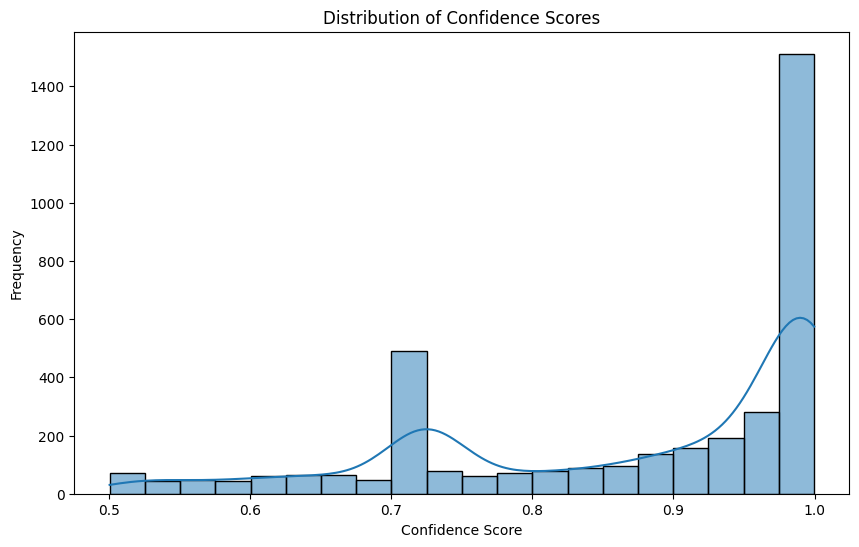

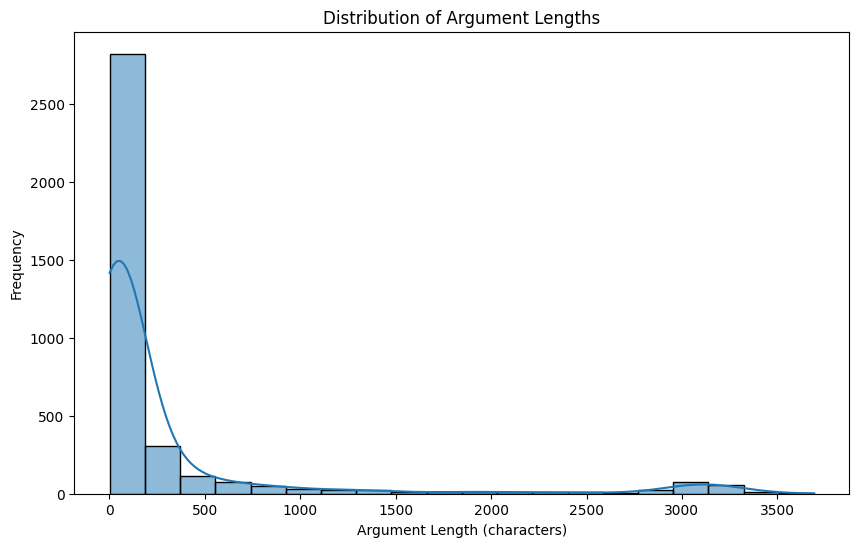

In [9]:
df_arguments_bert = pd.read_csv('bert_argument_results.csv')

# Rimuovi righe con valori NaN nella colonna 'argument'
df_arguments_bert = df_arguments_bert.dropna(subset=['argument'])

# Calcola statistiche
total_arguments = len(df_arguments_bert)
average_score = df_arguments_bert['score'].mean()
average_length = df_arguments_bert['argument'].apply(len).mean()

print(f"Total arguments found: {total_arguments}")
print(f"Average confidence score: {average_score:.2f}")
print(f"Average argument length: {average_length:.2f} characters")

# Visualizza la distribuzione dei punteggi di confidenza
plt.figure(figsize=(10, 6))
sns.histplot(df_arguments_bert['score'], bins=20, kde=True)
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.show()

# Visualizza la distribuzione della lunghezza degli argomenti
plt.figure(figsize=(10, 6))
sns.histplot(df_arguments_bert['argument'].apply(len), bins=20, kde=True)
plt.title('Distribution of Argument Lengths')
plt.xlabel('Argument Length (characters)')
plt.ylabel('Frequency')
plt.show()